# FINM 25000

### Review Notes 4 - Python Helper Guide

##### 7/8/2022

### Grantham, Mayo, and Van Otterloo, 2012: Estimating the Equity Risk Premium

In the past weeks we have discussed the following topics:

##### 1. Mean-Variance Optimization

##### 2. Tail Risk Measures and Hedging/Tracking with Regression 

##### 3. Factor Pricing Models

<br>

This week, we are exploring the question whether returns or risk premiums can be forecasted with some level of accuracy and what signals can we use to achieve that. Using a forecasting model, we'll construct a trading strategy and evaluate it's return compared to a passive investment strategy. Let's start by taking a closer look at GMO's investment strategy which is detailed in the case study this week. 

In [1]:
# Start by importing the packages and datasets for this week's homework

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def performanceMetrics(returns,annualization=1, quantile=.05):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    return metrics

def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    
    #Maximum Drawdown
    def maximumDrawdown(returns):
        cum_returns = (1 + returns).cumprod()
        rolling_max = cum_returns.cummax()
        drawdown = (cum_returns - rolling_max) / rolling_max

        max_drawdown = drawdown.min()
        end_date = drawdown.idxmin()
        summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

        for col in drawdown:
            summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
            recovery = (drawdown.loc[end_date[col]:,col])
            try:
                summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
            except:
                summary.loc[col,'Recover'] = pd.to_datetime(None)

            summary['Peak'] = pd.to_datetime(summary['Peak'])
            try:
                summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
            except:
                summary['Duration (to Recover)'] = None

            summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

        return summary  
    
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximumDrawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] = (metrics['Max Drawdown'] - returns.mean())/returns.std()

    return metrics


def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [2]:
# Start by reading in the data

rets = pd.read_excel('gmo_analysis_data.xlsx', 'returns (total)').set_index("Date")
display(rets.head())

signals = pd.read_excel('gmo_analysis_data.xlsx', 'signals').set_index("Date")
display(signals.head())

rf = pd.read_excel('gmo_analysis_data.xlsx', 'risk-free rate').set_index("Date")
display(rf.head())

,GMWAX,SPY
Date,,
1996-11-30,0.05,0.07
1996-12-31,-0.01,-0.02
1997-01-31,0.01,0.06
1997-02-28,0.02,0.01
1997-03-31,-0.02,-0.04


,DP,EP,US10Y
Date,,,
1996-11-30,2.01,5.14,6.06
1996-12-31,2.00,5.21,6.43
1997-01-31,1.95,5.12,6.53
1997-02-28,1.88,4.98,6.56
1997-03-31,1.90,5.08,6.92


,US3M
Date,
1996-11-30,0.00
1996-12-31,0.00
1997-01-31,0.00
1997-02-28,0.00
1997-03-31,0.00


## Analyzing GMO

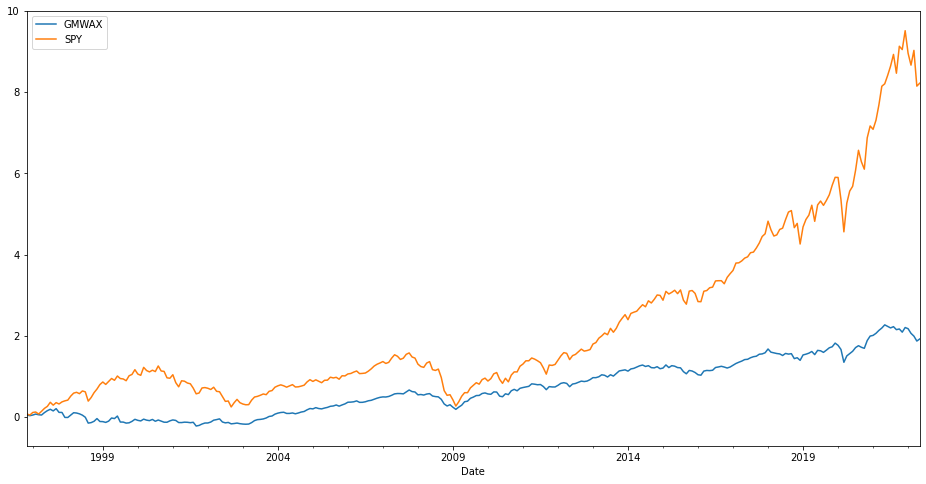

In [3]:
((1 + rets).cumprod() - 1).plot(figsize = (16,8))
plt.show()

### Performance of GMWAX compared to SPY

In [4]:
def gmo_performanceMetrics(data, annualization = 1, br = 2012):
    
    print('------------------- 1996 - '+ str(br-1) + ' -------------------')
    display(performanceMetrics(data.loc[:str(br-1)], annualization=annualization).style.format('{:,.2%}'))
    display(tailMetrics(data.loc[:str(br-1)]))
    print('')
    
    print('------------------- '+ str(br) + ' - Present -------------------')
    display(performanceMetrics(data.loc[str(br):], annualization=annualization).style.format('{:,.2%}'))
    display(tailMetrics(data.loc[str(br):]))
    print('')
    
    print('------------------- Complete Series -------------------')
    display(performanceMetrics(data, annualization=annualization).style.format('{:,.2%}'))
    display(tailMetrics(data))
    print('')

    
gmo_performanceMetrics(rets, annualization=12)

------------------- 1996 - 2011 -------------------


,Mean,Vol,Sharpe,Min,Max
GMWAX,4.45%,12.45%,35.73%,-14.50%,8.59%
SPY,6.87%,16.52%,41.56%,-16.52%,10.91%


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
GMWAX,-1.15,3.01,-0.06,-0.09,-0.36,1997-09-30,2001-09-30,2004-12-31,2649 days
SPY,-0.52,0.57,-0.08,-0.10,-0.51,2007-10-31,2009-02-28,NaT,NaT



------------------- 2012 - Present -------------------


,Mean,Vol,Sharpe,Min,Max
GMWAX,5.37%,8.66%,61.95%,-11.86%,7.14%
SPY,14.32%,13.40%,106.90%,-12.49%,12.70%


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
GMWAX,-0.83,4.04,-0.03,-0.05,-0.17,2019-12-31,2020-03-31,2020-11-30,335 days
SPY,-0.54,1.55,-0.06,-0.08,-0.19,2019-12-31,2020-03-31,2020-07-31,213 days



------------------- Complete Series -------------------


,Mean,Vol,Sharpe,Min,Max
GMWAX,4.82%,11.05%,43.64%,-14.50%,8.59%
SPY,9.90%,15.34%,64.56%,-16.52%,12.70%


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
GMWAX,-1.14,3.76,-0.04,-0.08,-0.36,1997-09-30,2001-09-30,2004-12-31,2649 days
SPY,-0.57,0.94,-0.07,-0.10,-0.51,2007-10-31,2009-02-28,2012-03-31,1613 days


We can see that:

1. Mean returns of GMWAX are lower than SPY and the difference has been increasing after the case
2. GMWAX's Sharpe has increased slightly on the account of low volatility since the case. However GMWAX's sharpe is almost half compared to the SPY for the period after the case study
3. GMWAX's tail risk is lower compared to SPY and has remained stable over time.

### Does GMWAX provide excess return?

In [5]:
retsx = rets.subtract(rf['US3M'], axis = 0)
retsx_pre = retsx.loc[:'2011']
retsx_post = retsx.loc['2012':]

print('-------------- Complete Series ------------------')
display(get_ols_metrics(retsx['SPY'], retsx['GMWAX'], annualization=12).style.format({'alpha': '{:,.2%}', 'SPY': '{:,.2f}', 'r-squared': '{:,.2%}', 'Treynor Ratio': '{:,.2f}', 'Info Ratio': '{:,.2f}'}))
print('')
print('-------------- Pre Case Study -------------------')
display(get_ols_metrics(retsx_pre['SPY'], retsx_pre['GMWAX'], annualization=12).style.format({'alpha': '{:,.2%}', 'SPY': '{:,.2f}', 'r-squared': '{:,.2%}', 'Treynor Ratio': '{:,.2f}', 'Info Ratio': '{:,.2f}'}))
print('')
print('-------------- Post Case Study ------------------')
display(get_ols_metrics(retsx_post['SPY'], retsx_post['GMWAX'], annualization=12).style.format({'alpha': '{:,.2%}', 'SPY': '{:,.2f}', 'r-squared': '{:,.2%}', 'Treynor Ratio': '{:,.2f}', 'Info Ratio': '{:,.2f}'}))
print('')

-------------- Complete Series ------------------


,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
GMWAX,-1.44%,0.54,56.36%,0.05,-0.20



-------------- Pre Case Study -------------------


,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
GMWAX,-0.58%,0.54,50.72%,0.03,-0.07



-------------- Post Case Study ------------------


,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
GMWAX,-2.84%,0.55,73.50%,0.09,-0.64


Clearly, GMWAX has been a relatively low beta strategy with a market beta of about 0.5. However, their strategy doesn't provide a significant benefit because of the negative alphas, which have been significantly lower since the case. This contributes to a lower Info Ratio 

## Forecast Regressions

A forecasting regression for the returns is of the form:

$$
r_{t+1} = \alpha + \beta X_t + \epsilon_{t+1} 
$$

where $X_t$ can be:

1. $r_t$ under the classical approach. This means that we are trying to predict the tomorrow's value based on the current value. This is sometimes also called an Autoregressive (AR) Model. However, given that returns don't have a lot of autocorrelation, this model has empirically not done so well.  
2. Signals or Factors derived from other sources such as marco-economic factors or asset price factors. Two such factors that the case talks about is Dividend-Price ratio and Earnings-Price ratio

In [6]:
# Shift the Signals by 1 period and take the corresponding values of SPY
signals_lag = signals.shift().dropna()
spy = rets[['SPY']].iloc[1:]

In [7]:
# Create the in-sample forcasting regressions
forecasts = rets[['SPY']].expanding().mean().shift(1).dropna()
forecasts.columns = ['Mean']

models = {'DP': ['DP'], 'EP':['EP'], 'ALL': signals.columns}
r2 = []

for model in models.keys():
    X = signals_lag[models[model]]
    reg_mod = LinearRegression().fit(X,spy)
    forecasts[model] = reg_mod.predict(X)
    r2.append(reg_mod.score(X, spy))
    
forecasts.dropna(inplace=True)
forecasts['Actuals'] = spy['SPY']
display(pd.DataFrame({'R-squared': r2}, index = models.keys()).style.format('{:,.4%}'))

,R-squared
DP,0.8991%
EP,0.5251%
ALL,1.4931%


### Creating a Trading Strategy

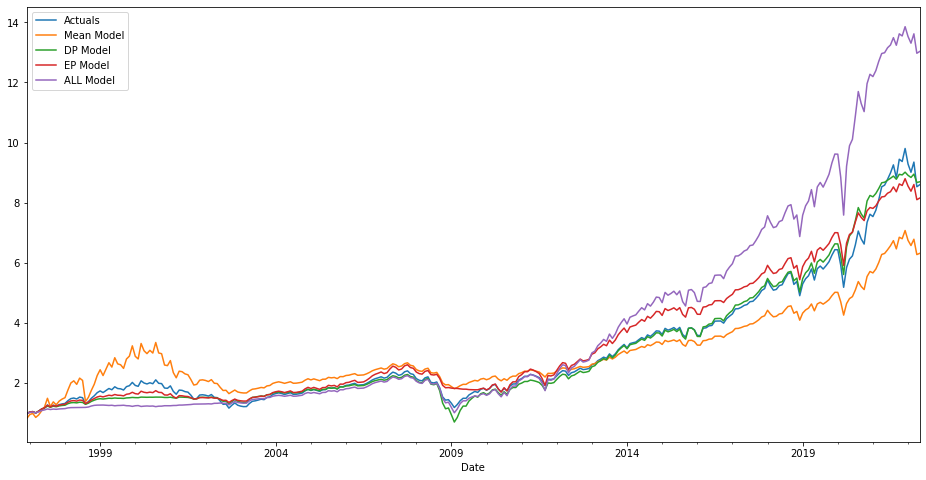

In [8]:
forecasts['Mean_wt'] = forecasts['Mean'] * 100
forecasts['DP_wt'] = forecasts['DP'] * 100
forecasts['EP_wt'] = forecasts['EP'] * 100
forecasts['ALL_wt'] = forecasts['ALL'] * 100

forecasts['Mean Model'] = forecasts['Mean_wt'] * forecasts['Actuals']
forecasts['DP Model'] = forecasts['DP_wt'] * forecasts['Actuals']
forecasts['EP Model'] = forecasts['EP_wt'] * forecasts['Actuals']
forecasts['ALL Model'] = forecasts['ALL_wt'] * forecasts['Actuals']

(1 + forecasts[['Actuals','Mean Model','DP Model', 'EP Model', 'ALL Model']]).cumprod().plot(figsize = (16,8))
plt.show()

### Comparing the Strategy to the Risk Free Rate

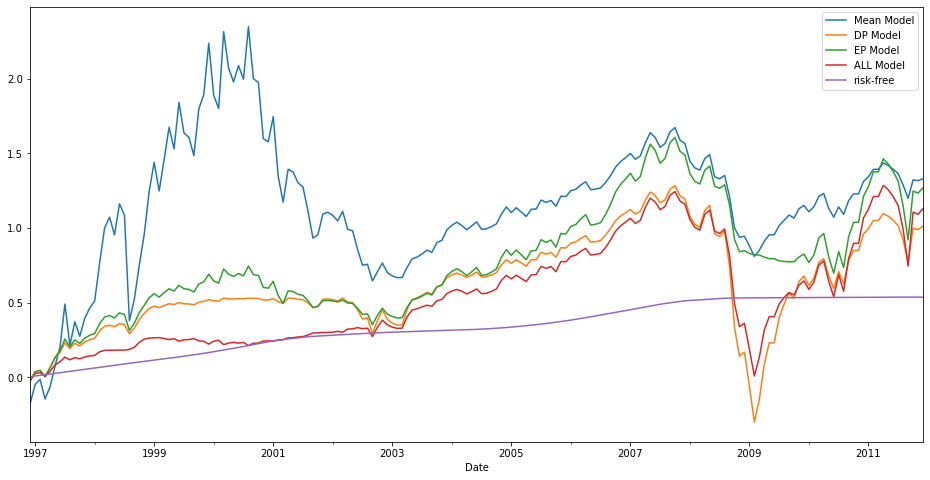

In [9]:
forecasts['risk-free'] = rf['US3M'].iloc[1:]
((1 + forecasts[['Mean Model', 'DP Model', 'EP Model', 'ALL Model', 'risk-free']].loc[:'2011']).cumprod() - 1).plot(figsize = (16,8))
plt.show()

### Analyzing Strategy Performance

In [10]:
performanceMetrics(forecasts[['Mean Model', 'DP Model', 'EP Model', 'ALL Model', 'risk-free']])\
.style.format('{:,.2%}')

,Mean,Vol,Sharpe,Min,Max
Mean Model,0.76%,5.48%,13.82%,-33.90%,24.11%
DP Model,0.82%,4.71%,17.46%,-25.57%,27.60%
EP Model,0.75%,3.50%,21.40%,-10.67%,17.07%
ALL Model,0.94%,4.37%,21.45%,-17.61%,21.43%
risk-free,0.16%,0.17%,95.68%,0.00%,0.53%


In [11]:
tailMetrics(forecasts[['Mean Model', 'DP Model', 'EP Model', 'ALL Model']])

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
Mean Model,-0.49,7.26,-0.07,-0.12,-0.51,2000-08-31,2002-09-30,2014-11-30,5204 days
DP Model,-0.33,10.77,-0.06,-0.11,-0.69,2007-10-31,2009-02-28,2012-03-31,1613 days
EP Model,0.04,2.34,-0.06,-0.07,-0.35,2007-10-31,2010-06-30,2012-03-31,1613 days
ALL Model,0.11,5.22,-0.07,-0.10,-0.55,2007-10-31,2009-02-28,2011-04-30,1277 days


In [12]:
get_ols_metrics(spy, forecasts[['Mean Model', 'DP Model', 'EP Model', 'ALL Model']])\
.style.format({'alpha': '{:,.2%}', 'SPY': '{:,.2f}', 'r-squared': '{:,.2%}', 'Treynor Ratio': '{:,.2f}', 'Info Ratio': '{:,.2f}'})

,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
Mean Model,-0.06%,1.01,66.53%,0.01,-0.02
DP Model,0.11%,0.89,69.67%,0.01,0.04
EP Model,0.18%,0.71,79.68%,0.01,0.11
ALL Model,0.31%,0.78,62.56%,0.01,0.12


In [13]:
print('% of days DP model forecast negative excess return: {:,.2%}'.format(sum(forecasts['DP'] < forecasts['risk-free'])/len(forecasts)))
print('% of days EP model forecast negative excess return: {:,.2%}'.format(sum(forecasts['EP'] < forecasts['risk-free'])/len(forecasts)))
print('% of days ALL model forecast negative excess return: {:,.2%}'.format(sum(forecasts['ALL'] < forecasts['risk-free'])/len(forecasts)))


% of days DP model forecast negative excess return: 12.42%
% of days EP model forecast negative excess return: 2.61%
% of days ALL model forecast negative excess return: 19.93%
